In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


In [2]:
read_dp <- function(arch, capture, coverages) {
    arch_gt <-
        future_map(coverages, function(x) {
            read_genotypes(arch, capture, mindp = x, var_only = TRUE) %>%
                select(!!arch) %>%
                setNames(paste0(arch, "_dp", x))
        }) %>% bind_cols

    highcov_gt <- read_genotypes(arch, capture, mindp = 1, var_only = TRUE) %>%
        select(chrom, pos, REF, ALT, a00, S_Dinka_1, S_French_1)
    
    bind_cols(arch_gt, highcov_gt)
}

In [3]:
den4 <- read_dp("den4", "full", 1:8) %>% snp_props(normalize = "T-C")
den8 <- read_dp("den8", "full", 1:8) %>% snp_props(normalize = "T-C")
spy1 <- read_dp("spy1", "full", 1:8) %>% snp_props(normalize = "T-C")
mez2 <- read_dp("mez2", "full", 1:8) %>% snp_props(normalize = "T-C")

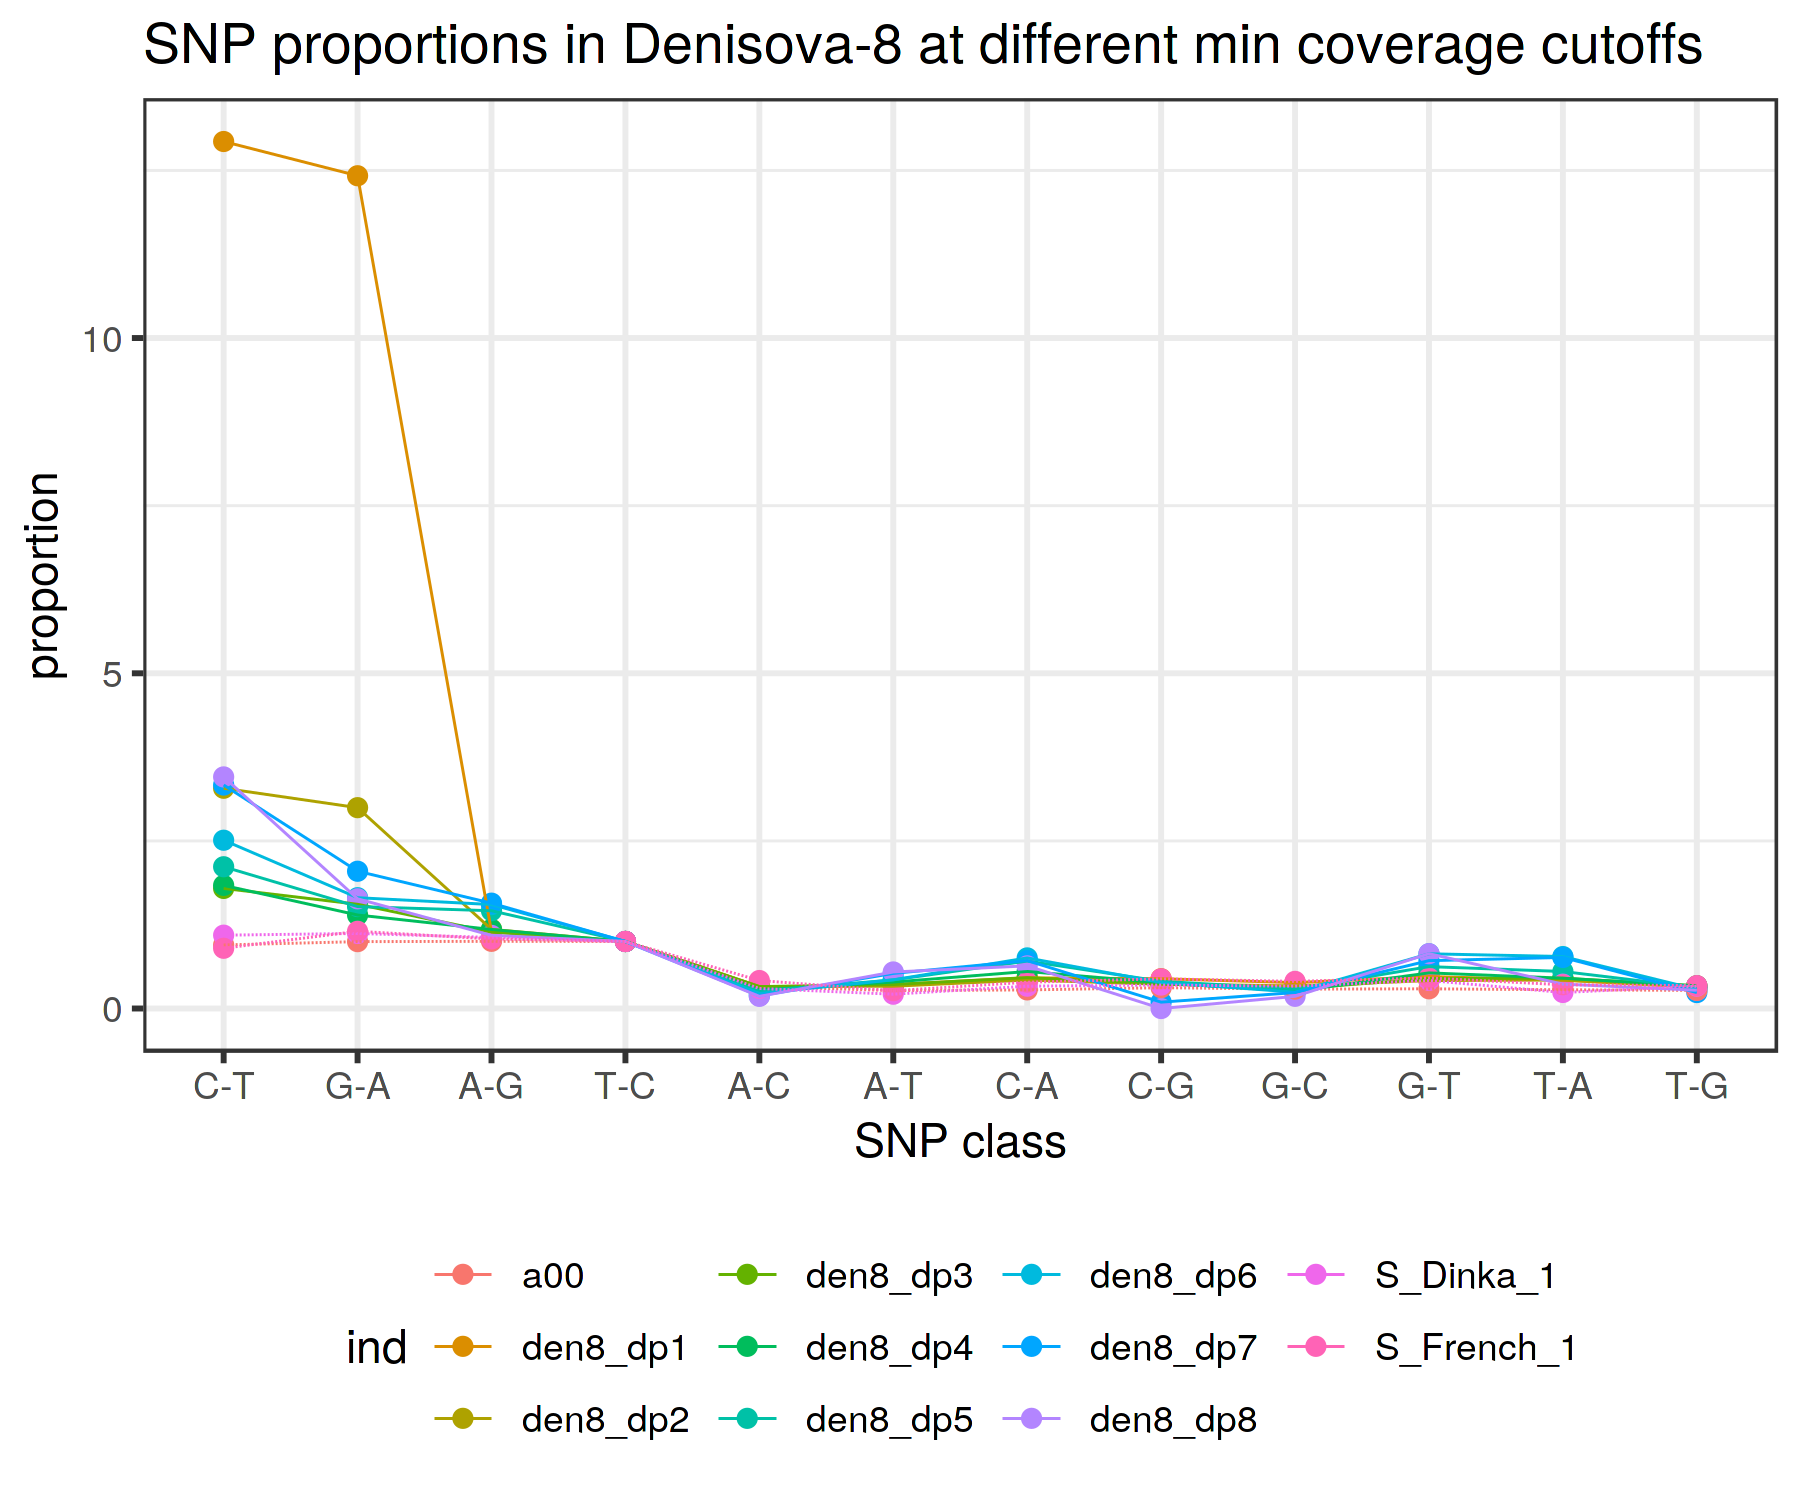

In [4]:
set_dim(6, 5)

den8 %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different min coverage cutoffs")

Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_path).”

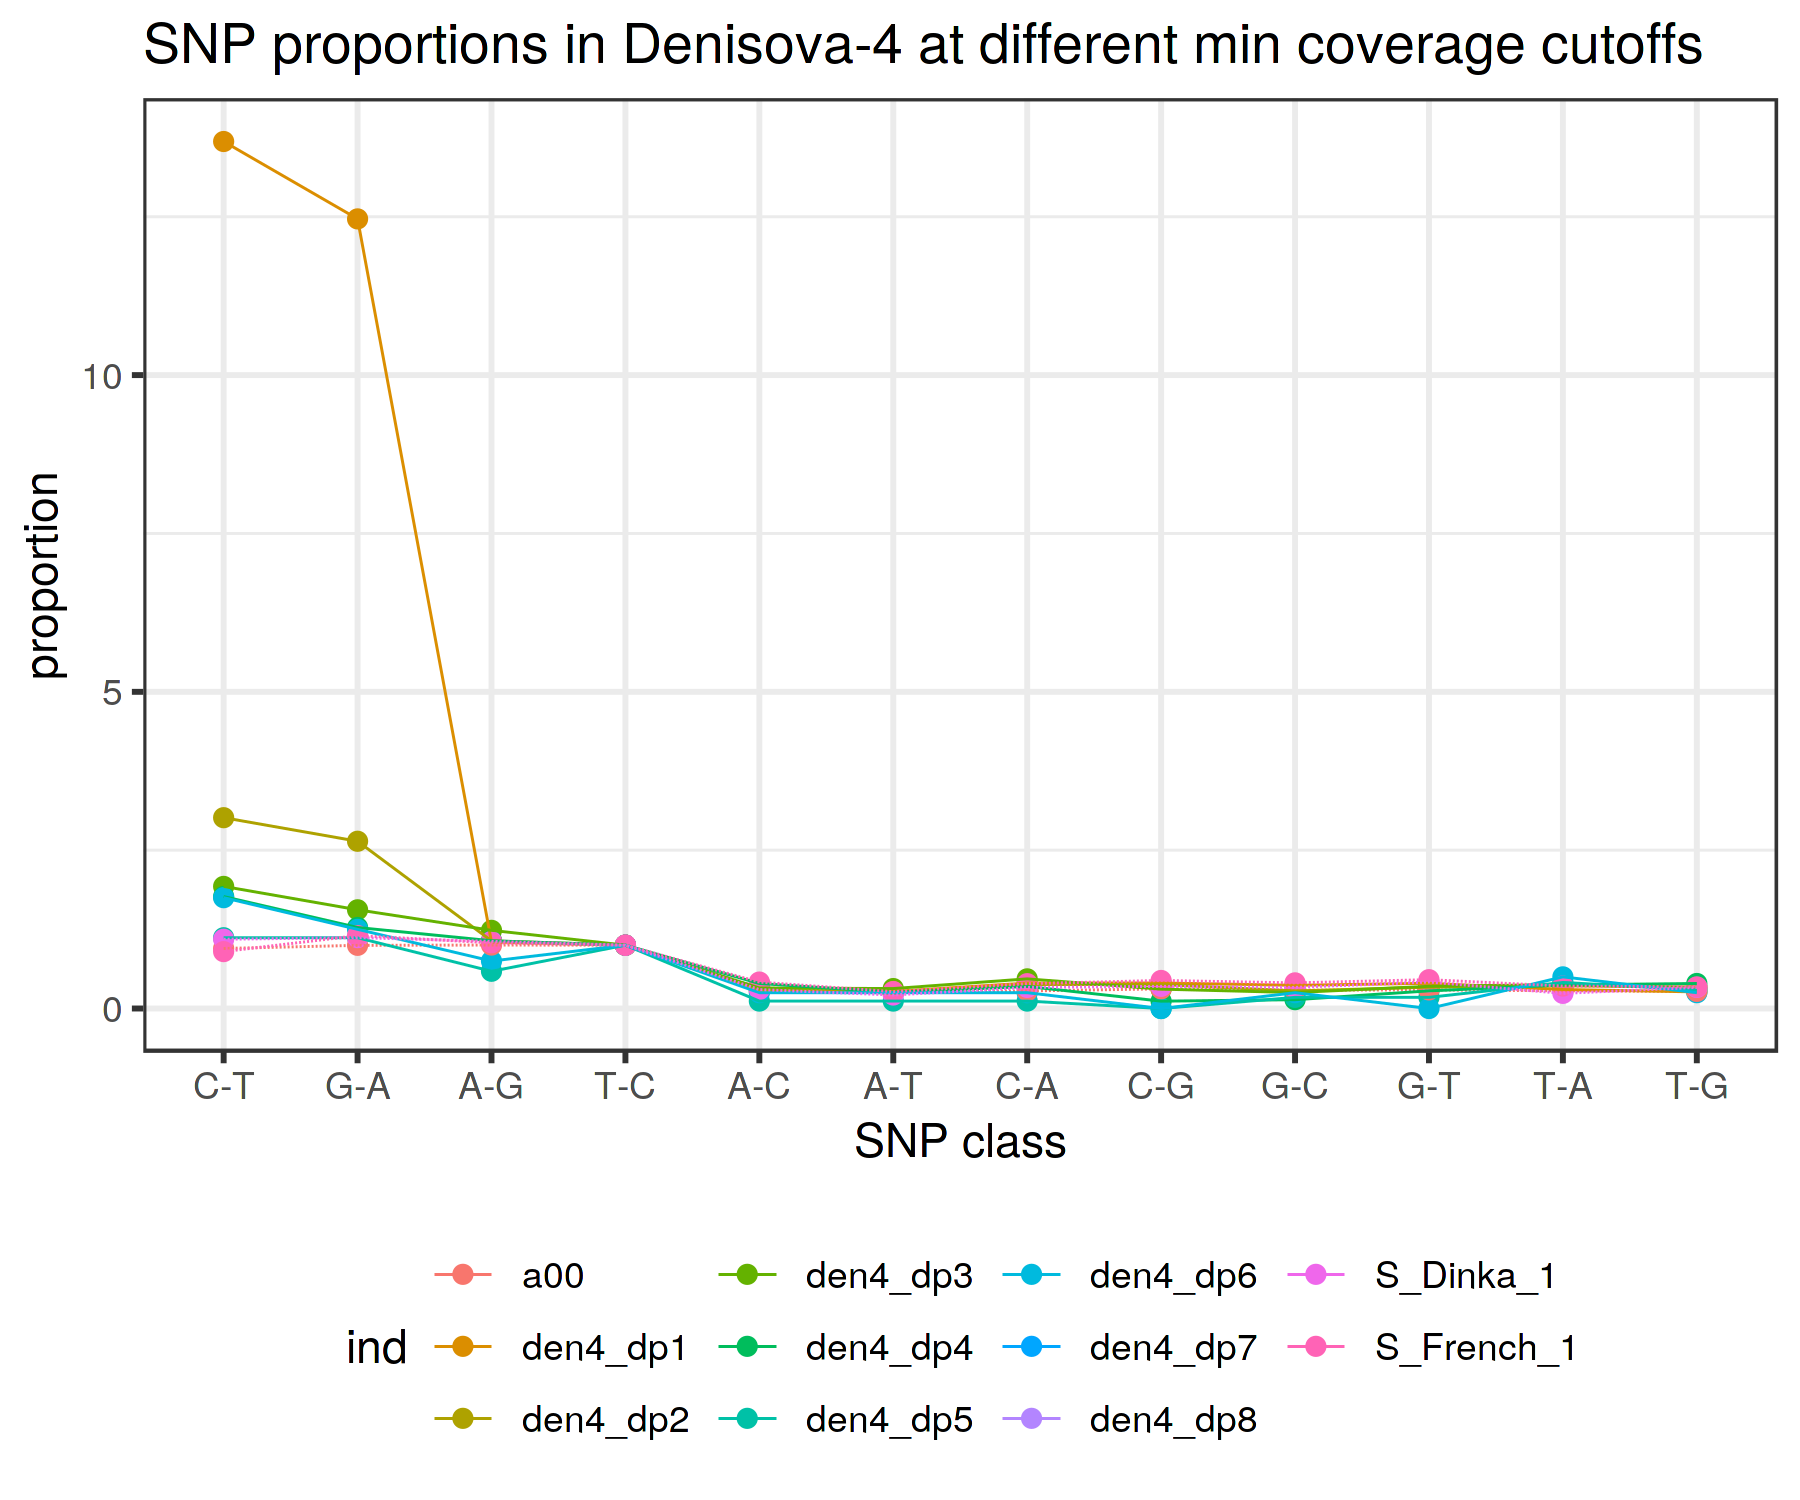

In [10]:
set_dim(6, 5)

den4 %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den4")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-4 at different min coverage cutoffs")

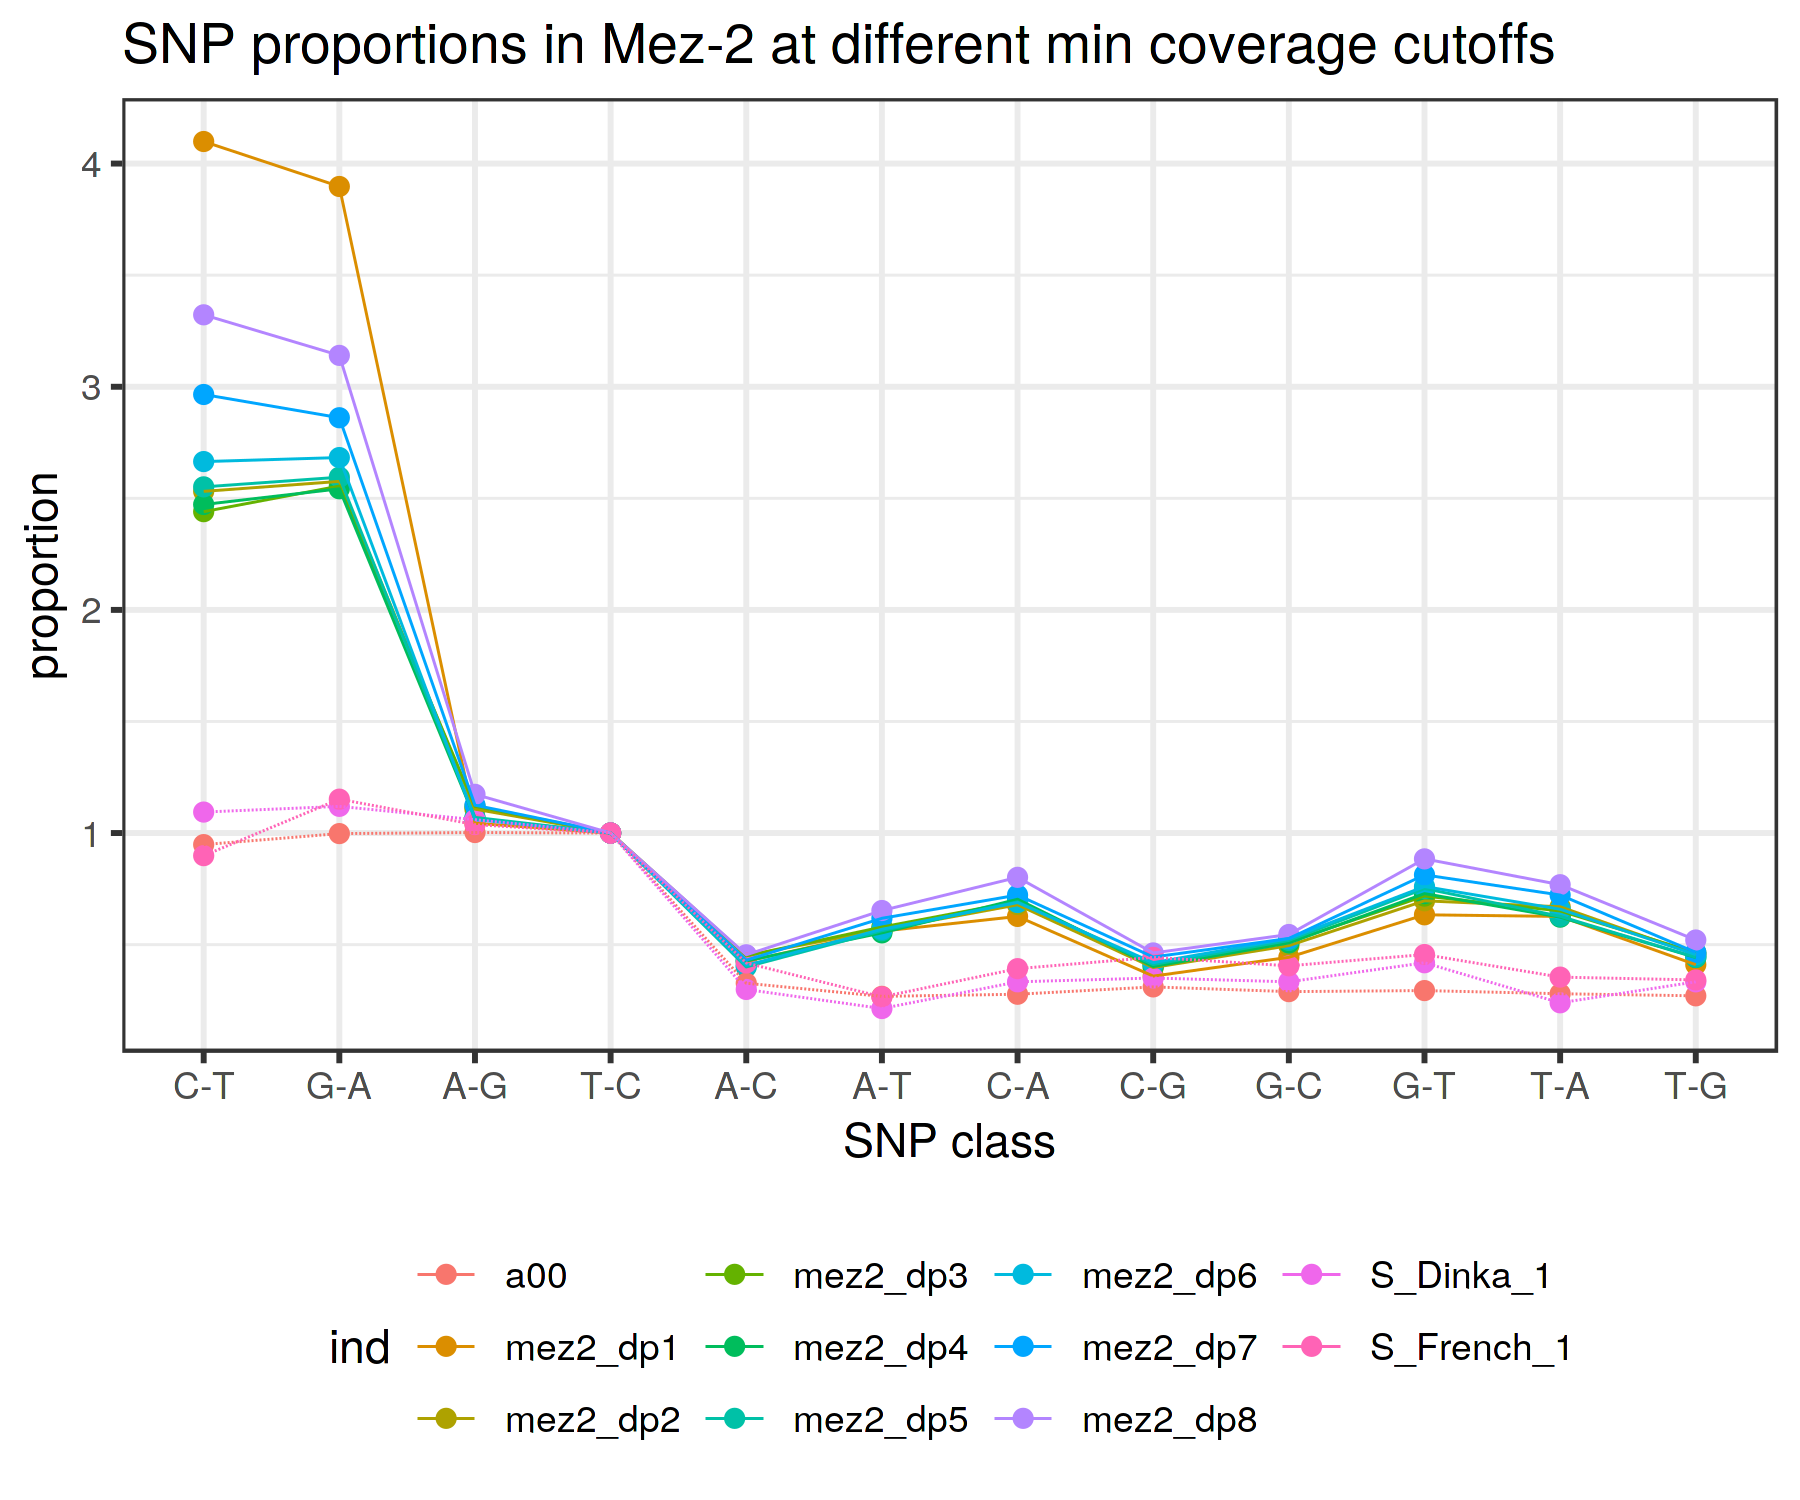

In [11]:
set_dim(6, 5)

mez2 %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "mez2")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez-2 at different min coverage cutoffs")

Warning message:
“Removed 36 rows containing missing values (geom_point).”Warning message:
“Removed 36 rows containing missing values (geom_path).”

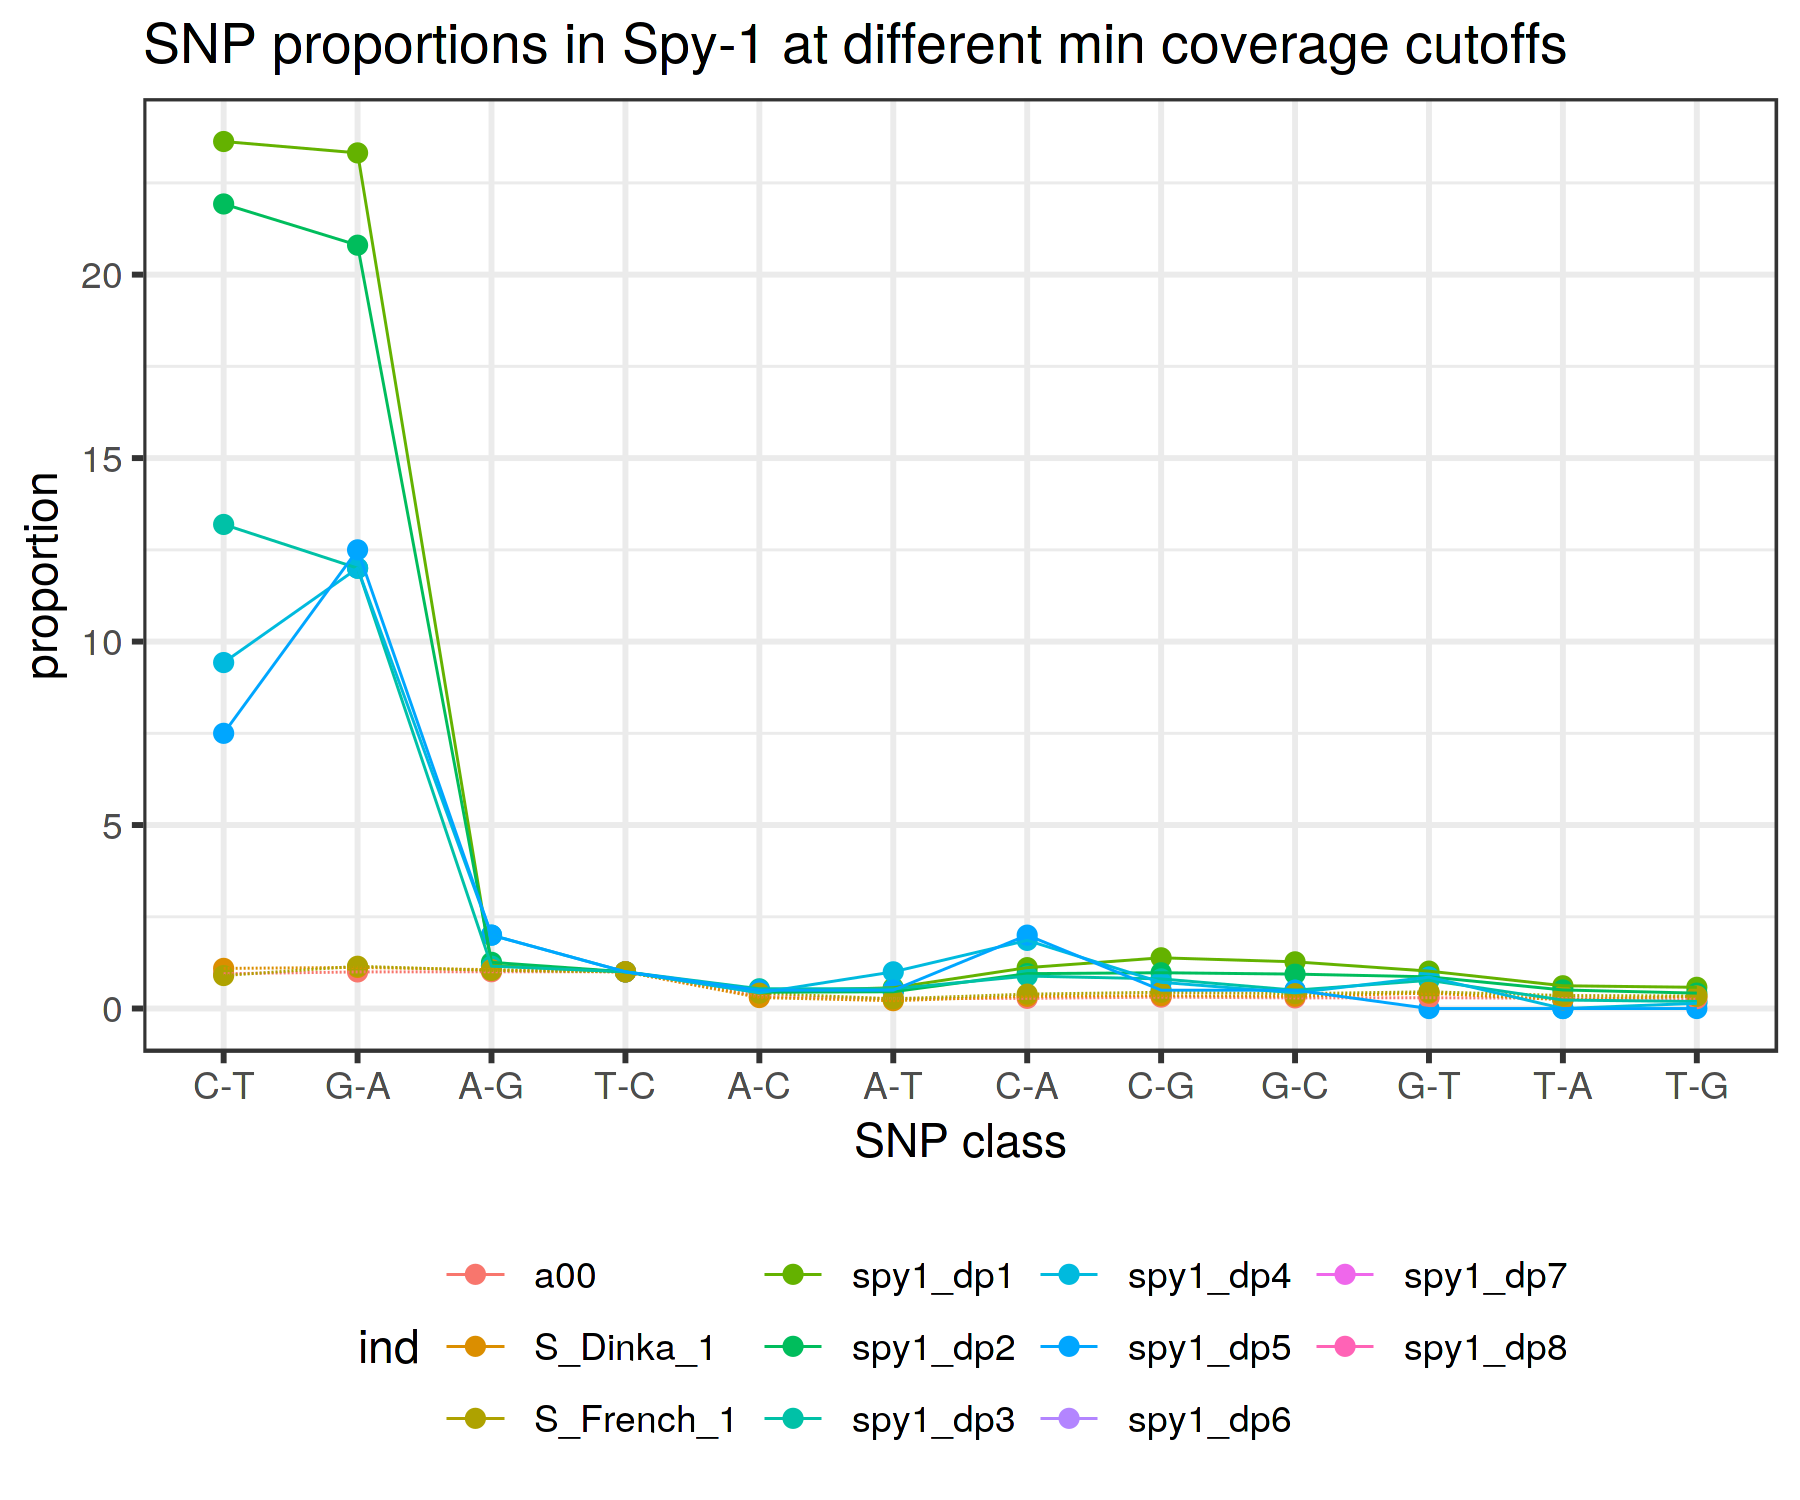

In [14]:
set_dim(6, 5)

spy1 %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "spy1")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Spy-1 at different min coverage cutoffs")

In [9]:
den8_props <- snp_props(den8_gt, normalize = "T-C")

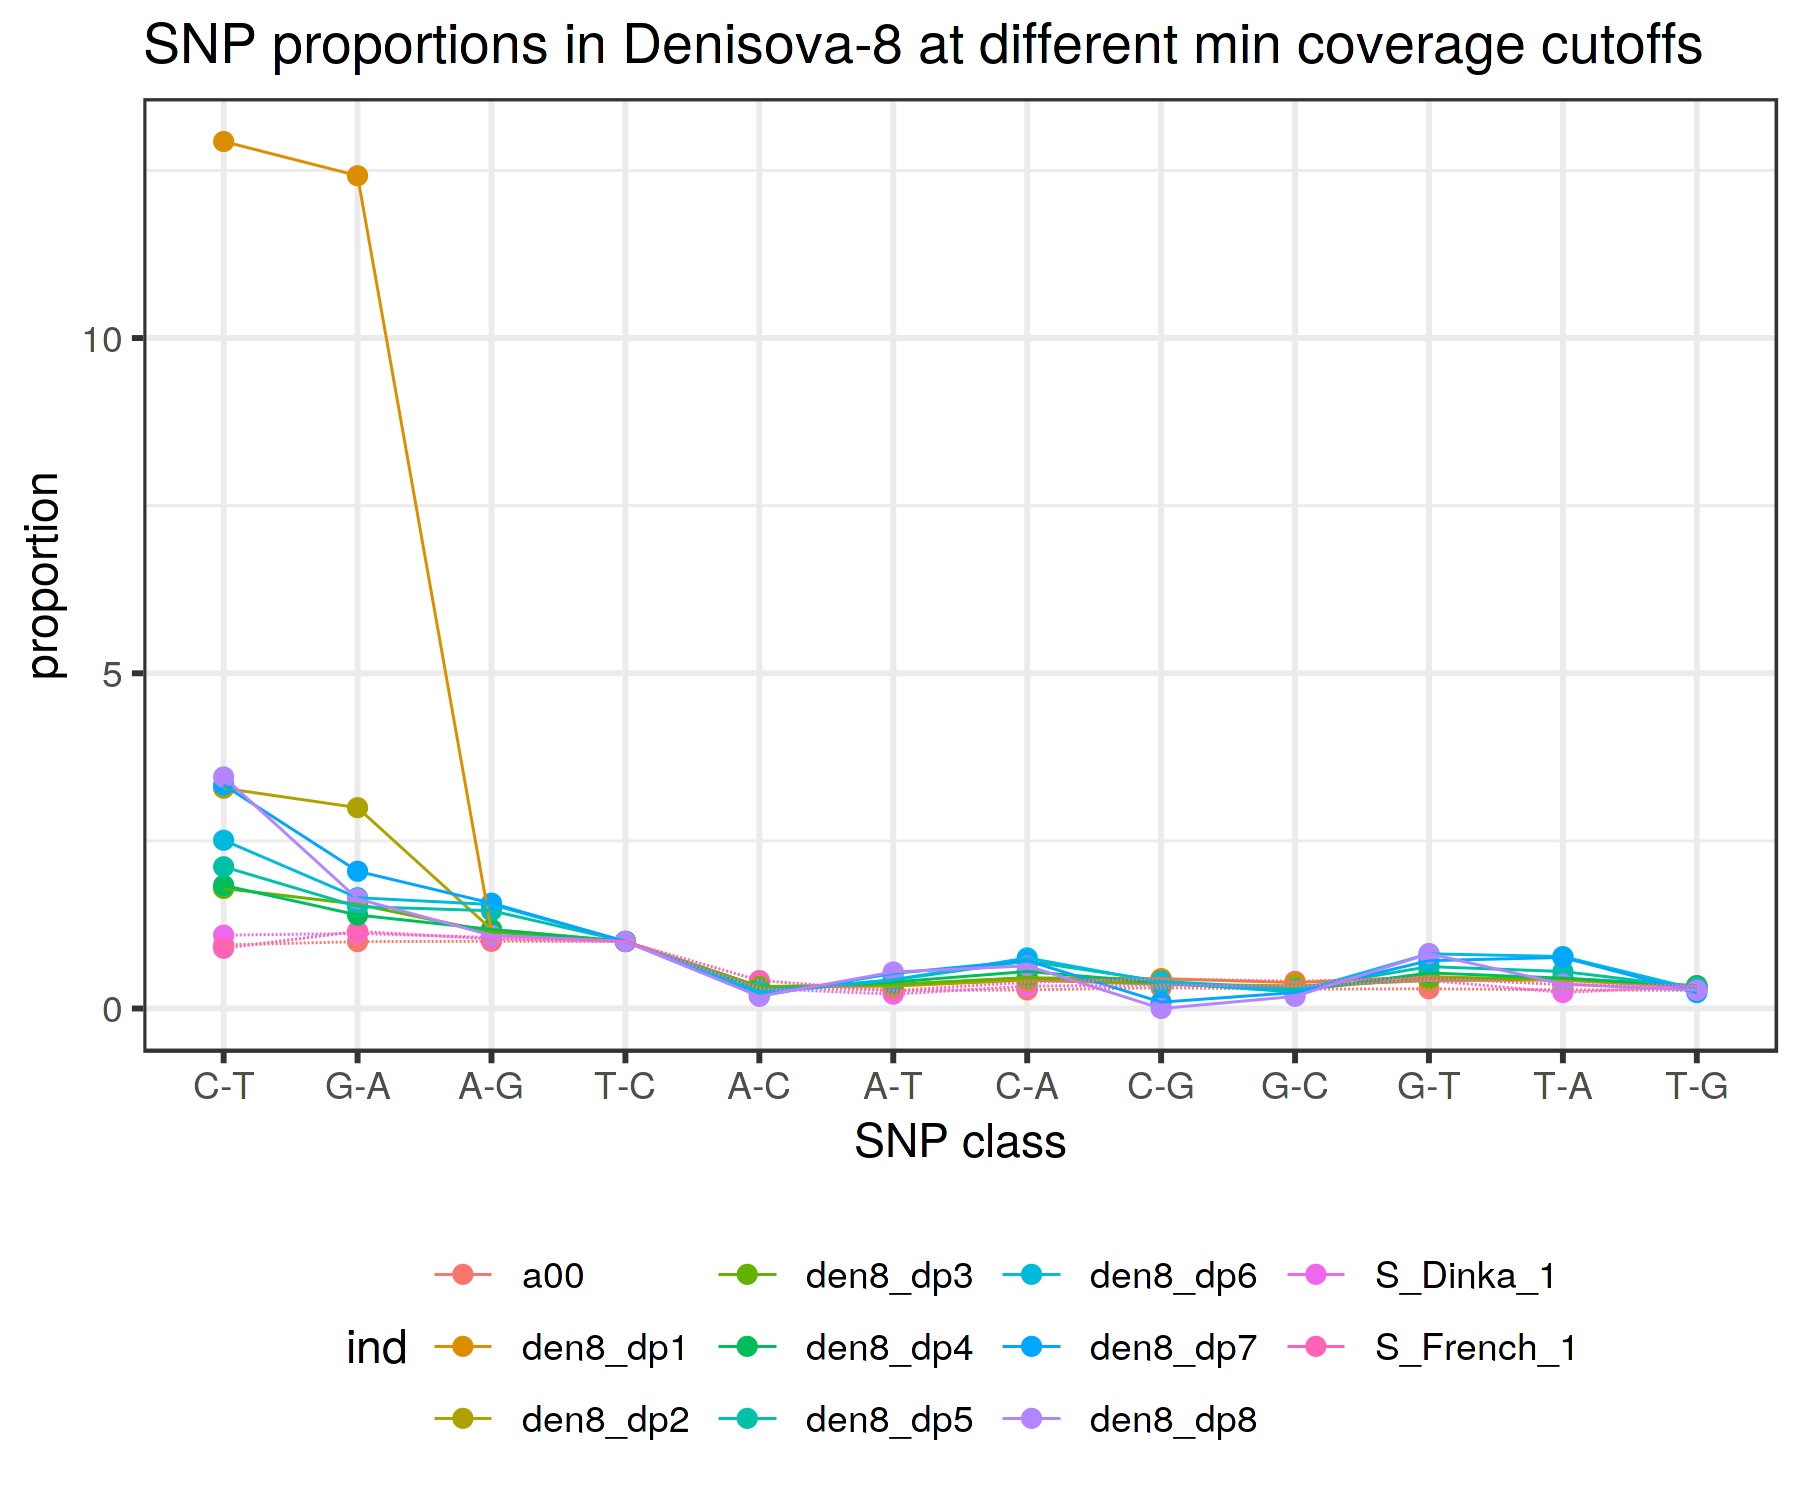

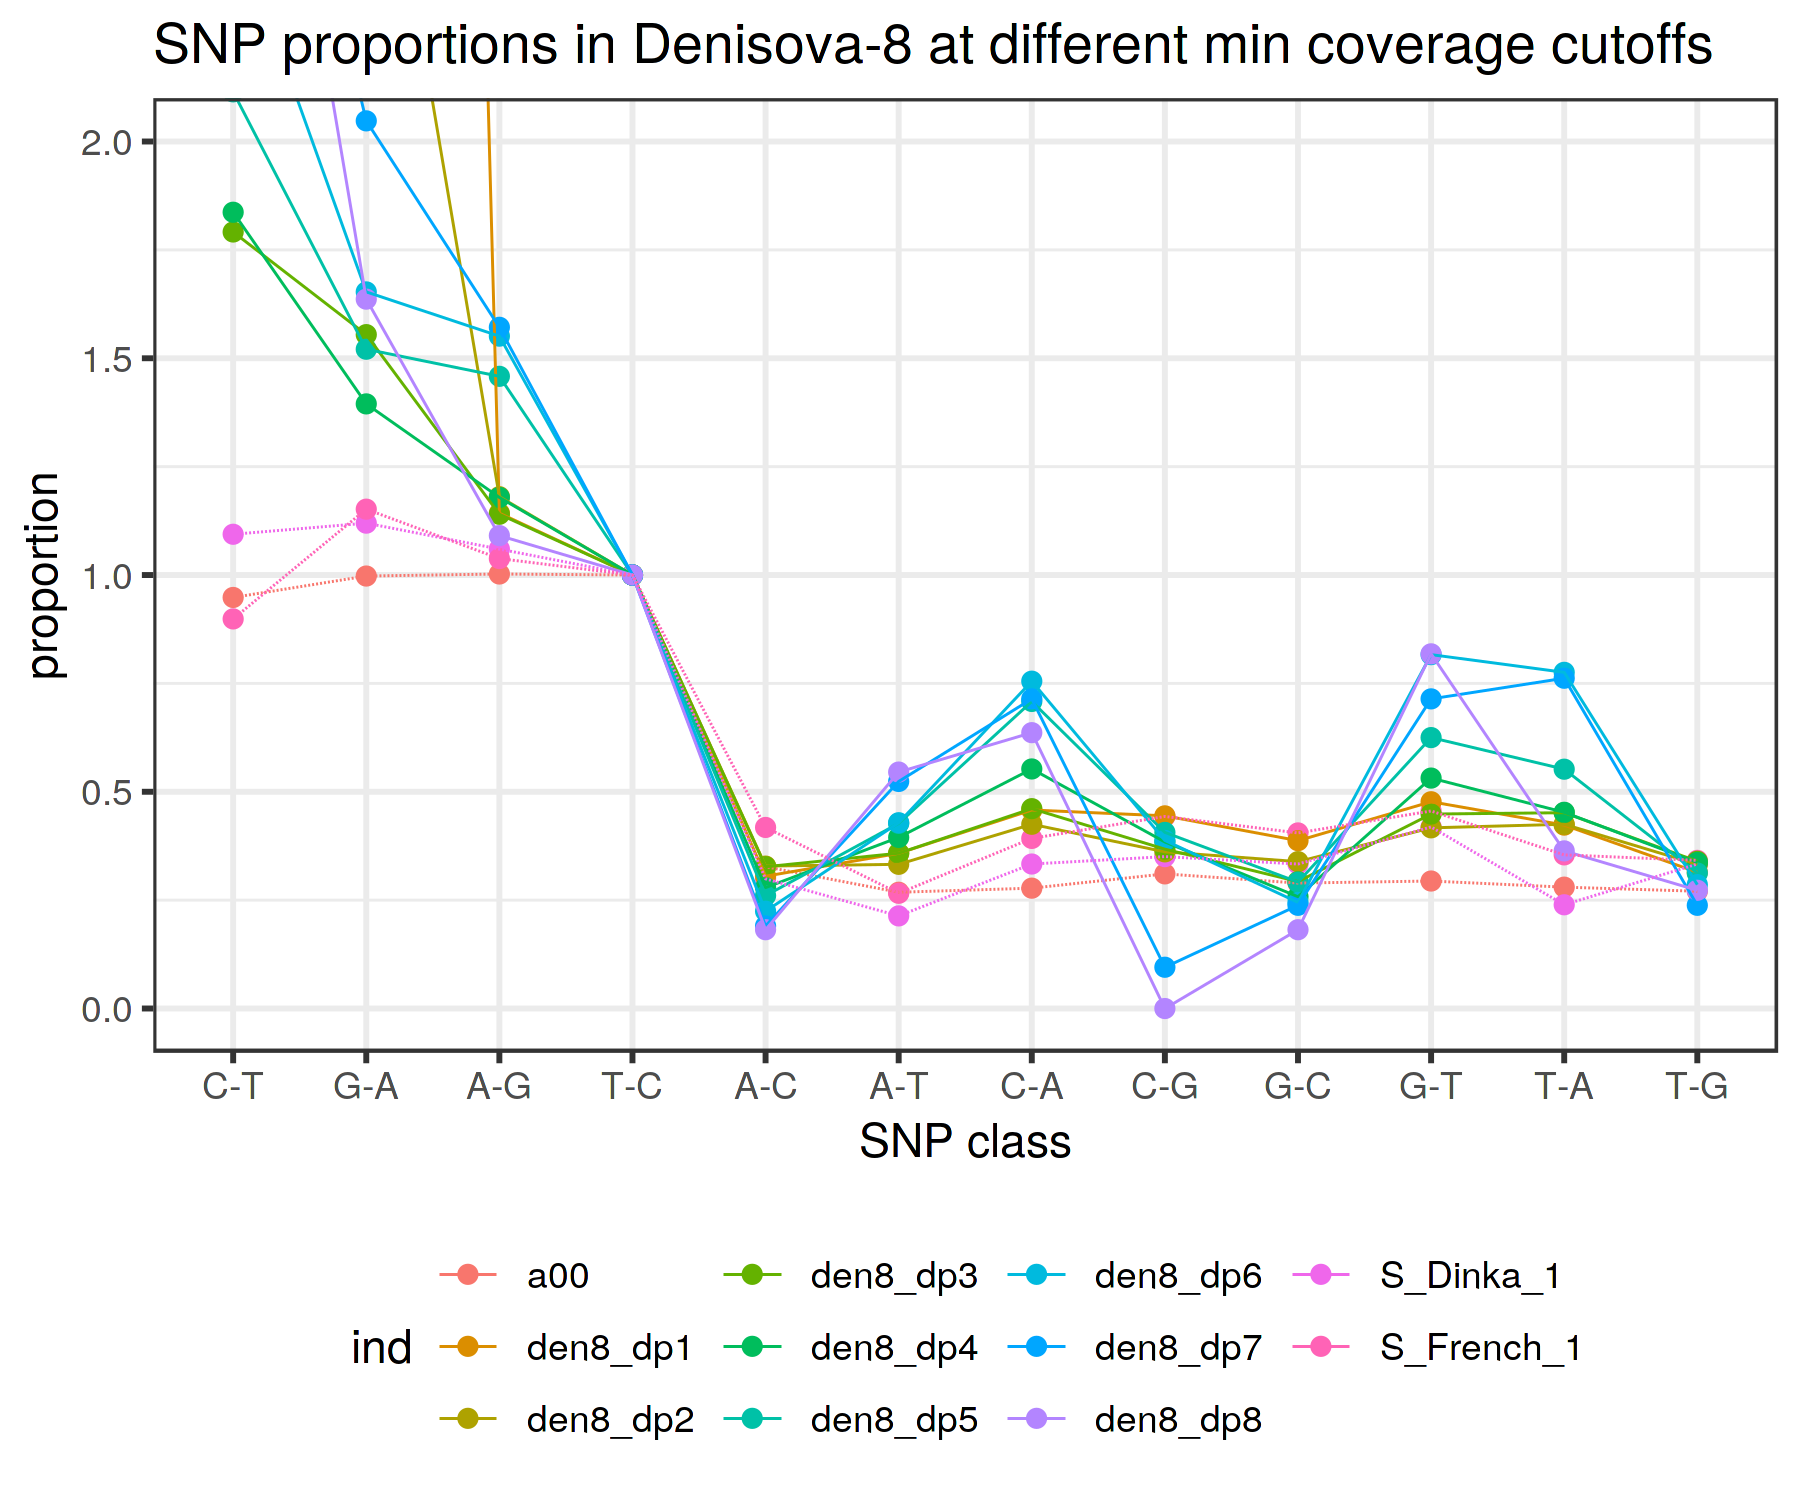

In [10]:
set_dim(6, 5)

den8_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different min coverage cutoffs")

den8_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different min coverage cutoffs")

In [17]:
den4_props <- snp_props(den4_gt, normalize = "T-C")

Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_path).”Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_path).”

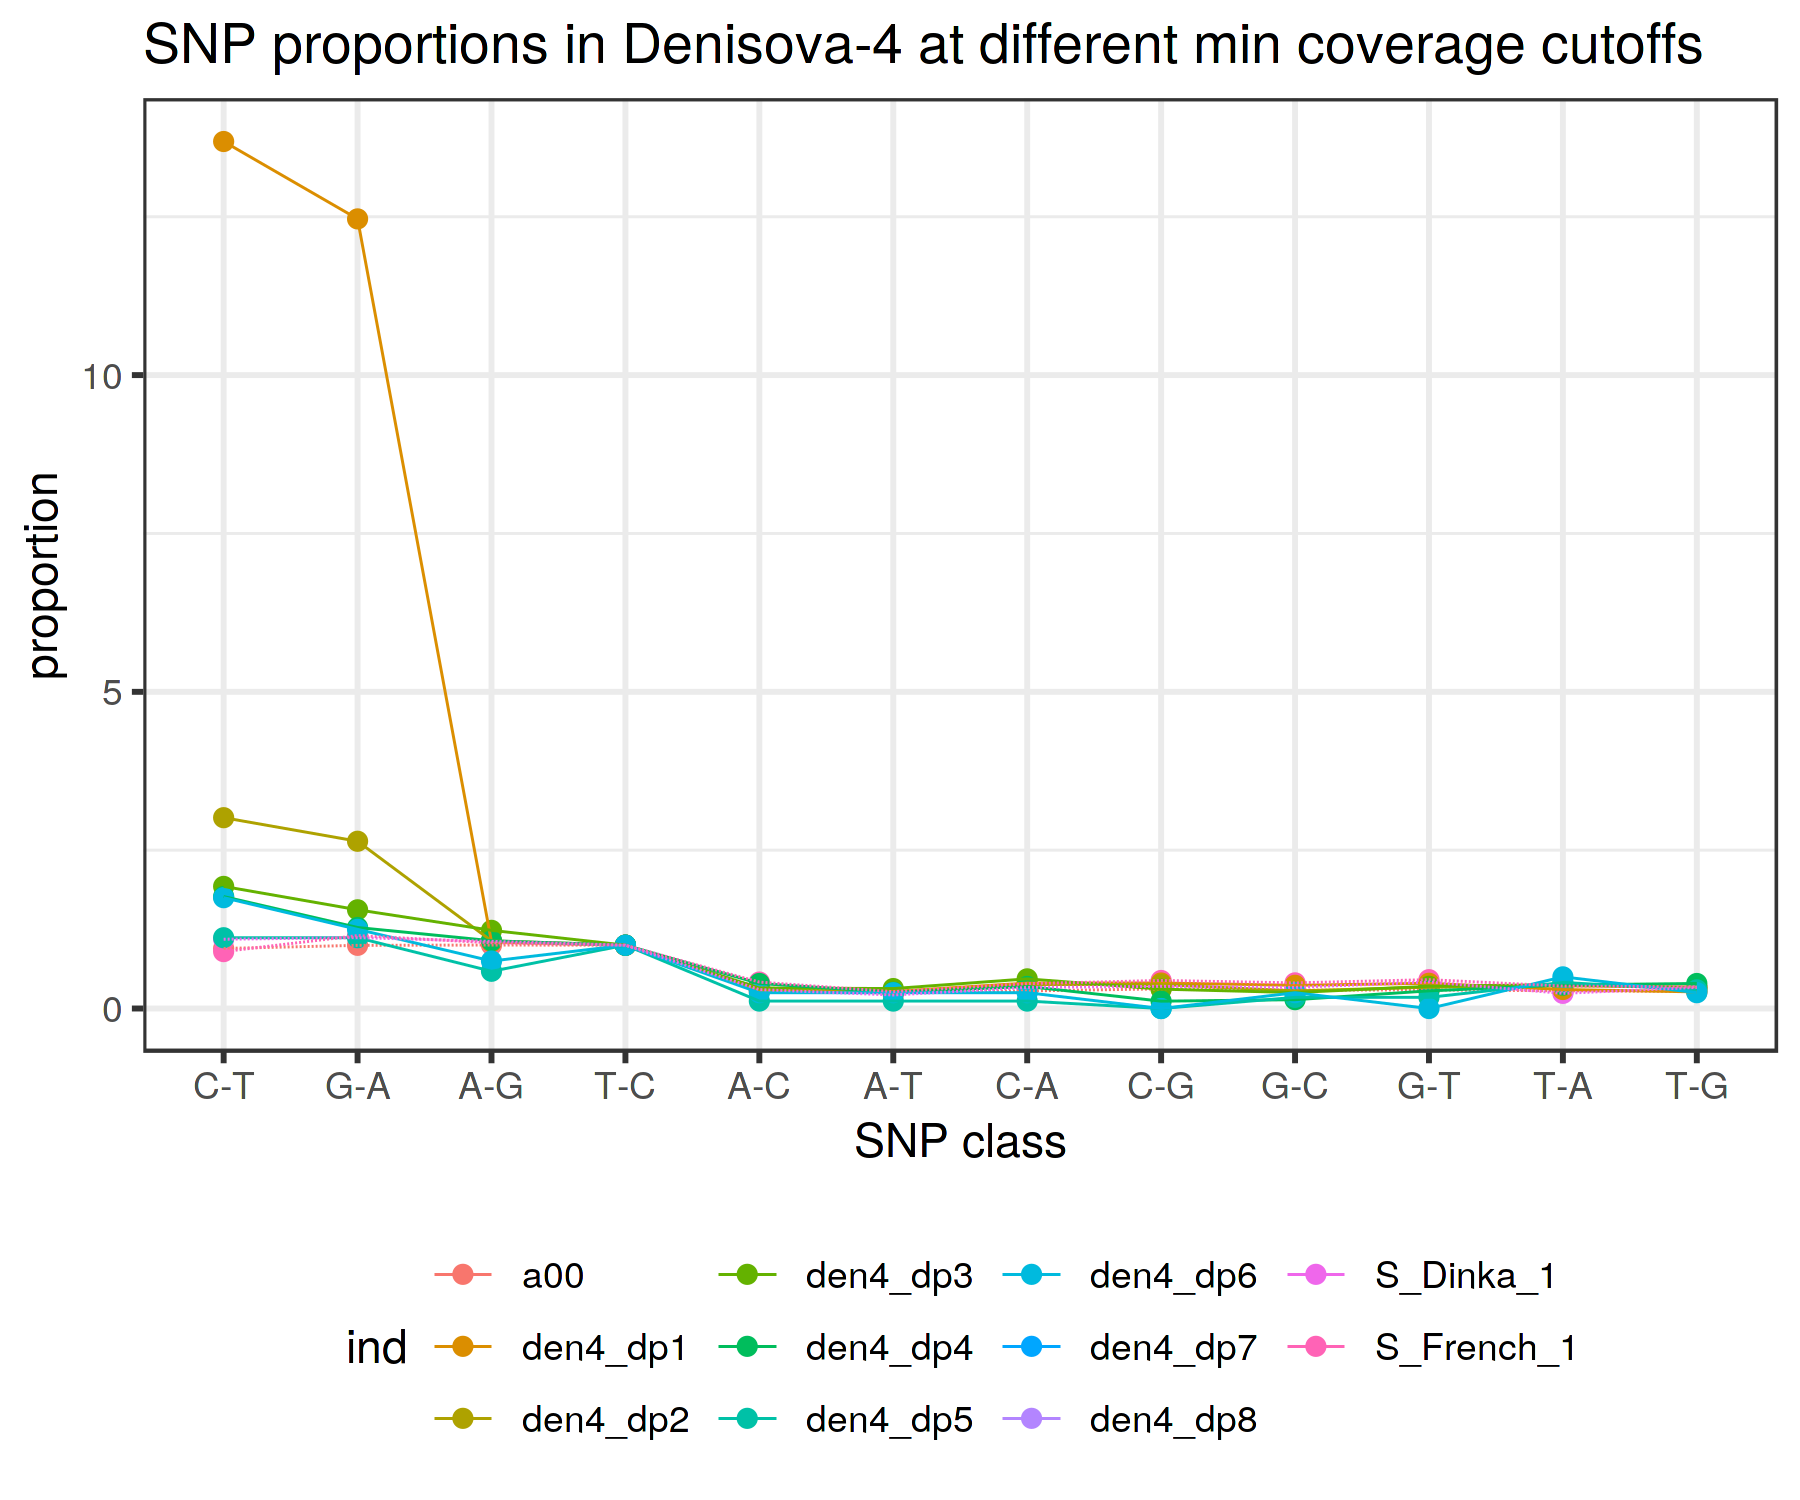

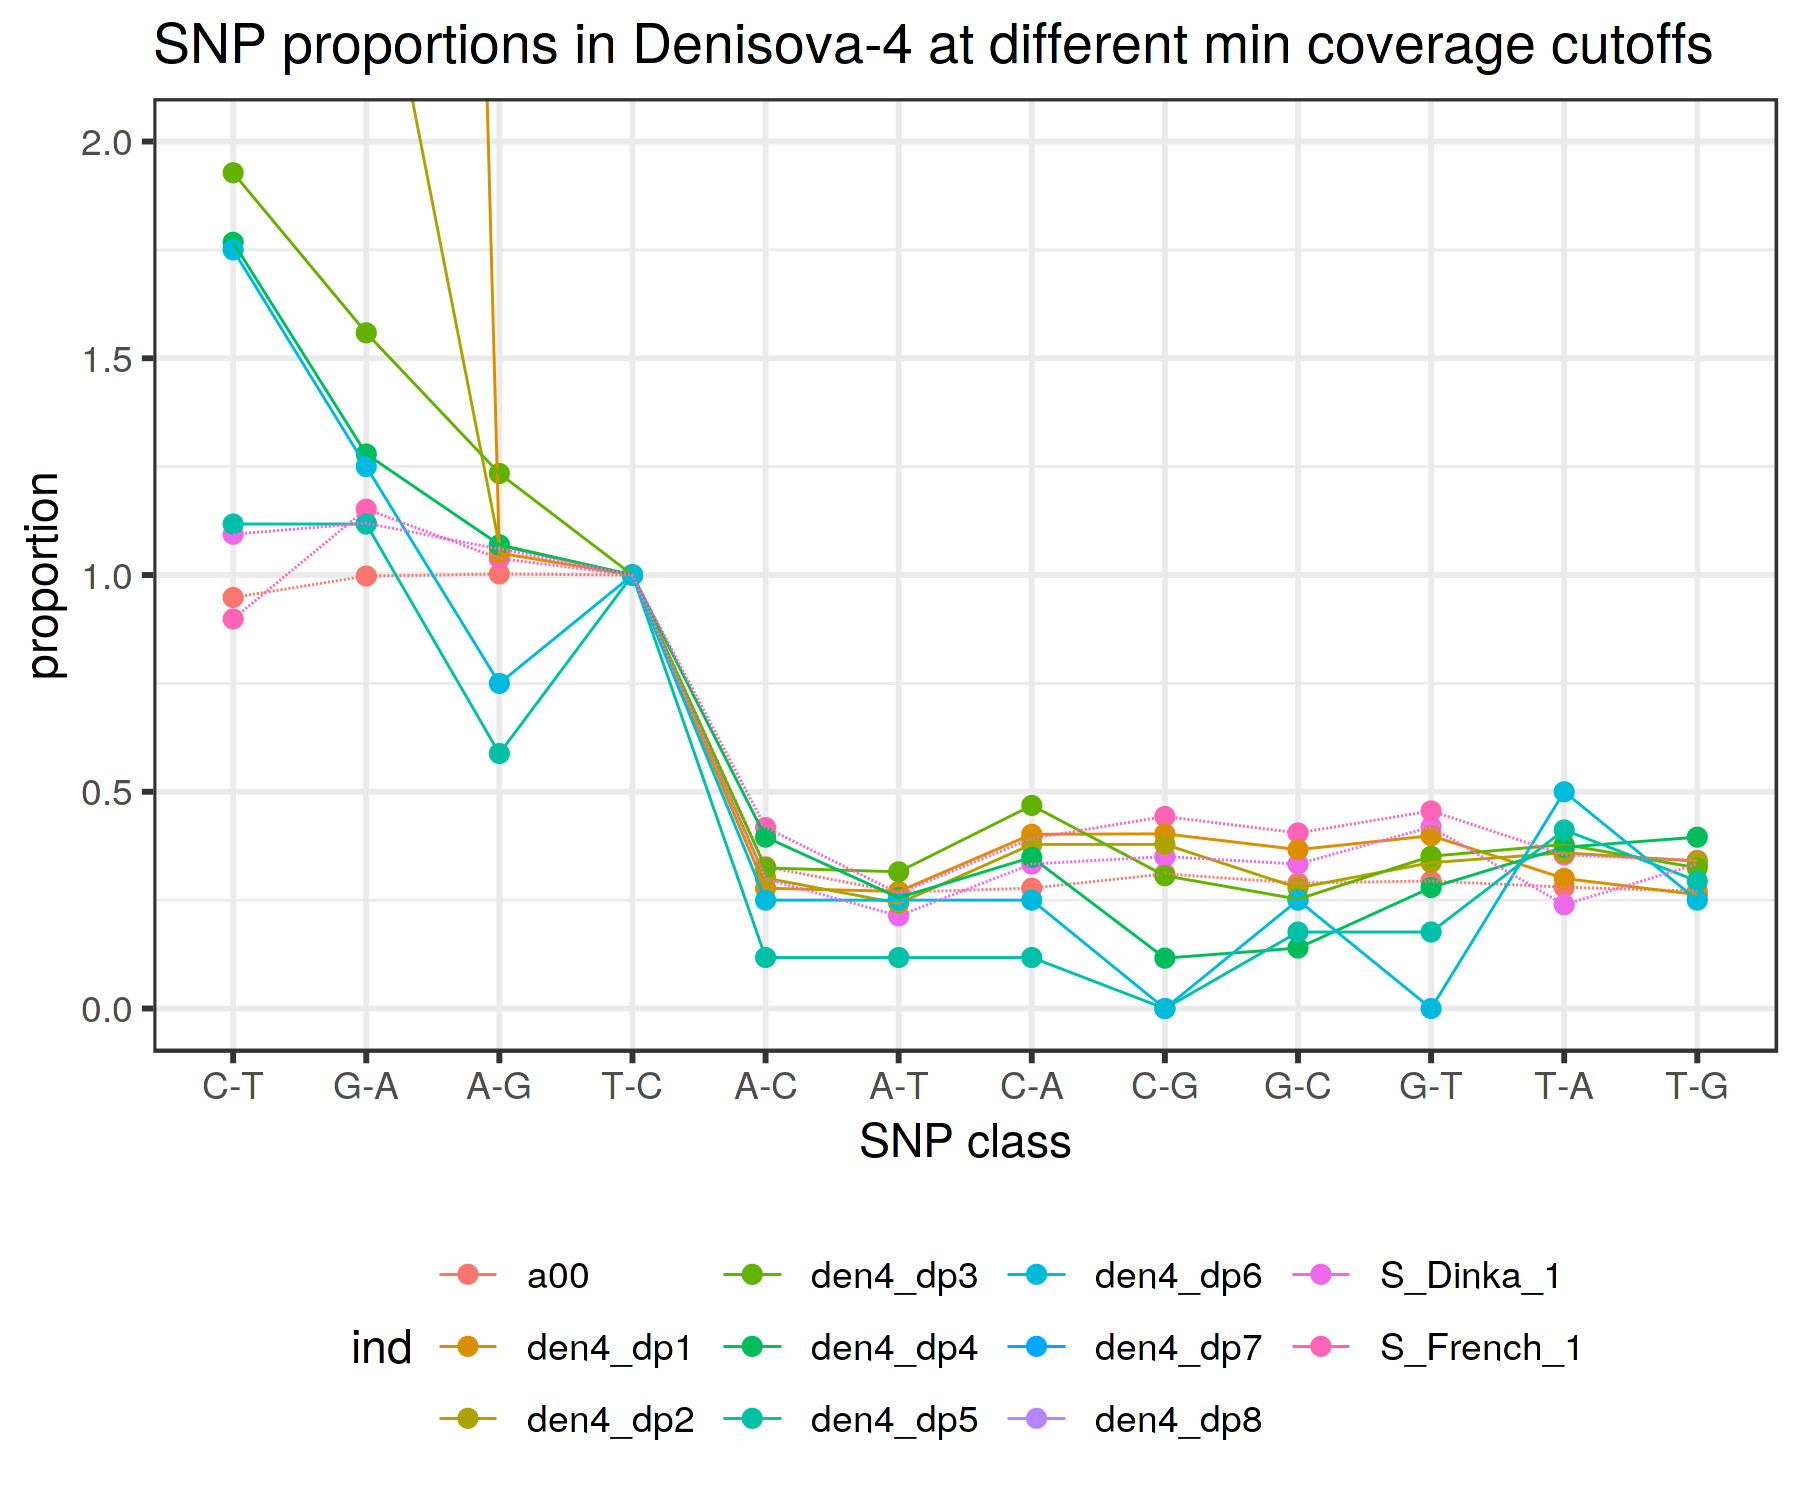

In [19]:
set_dim(6, 5)

den4_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den4")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-4 at different min coverage cutoffs")

den4_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den4")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-4 at different min coverage cutoffs")

In [11]:
neand_props <- snp_props(neand_gt, normalize = "T-C")

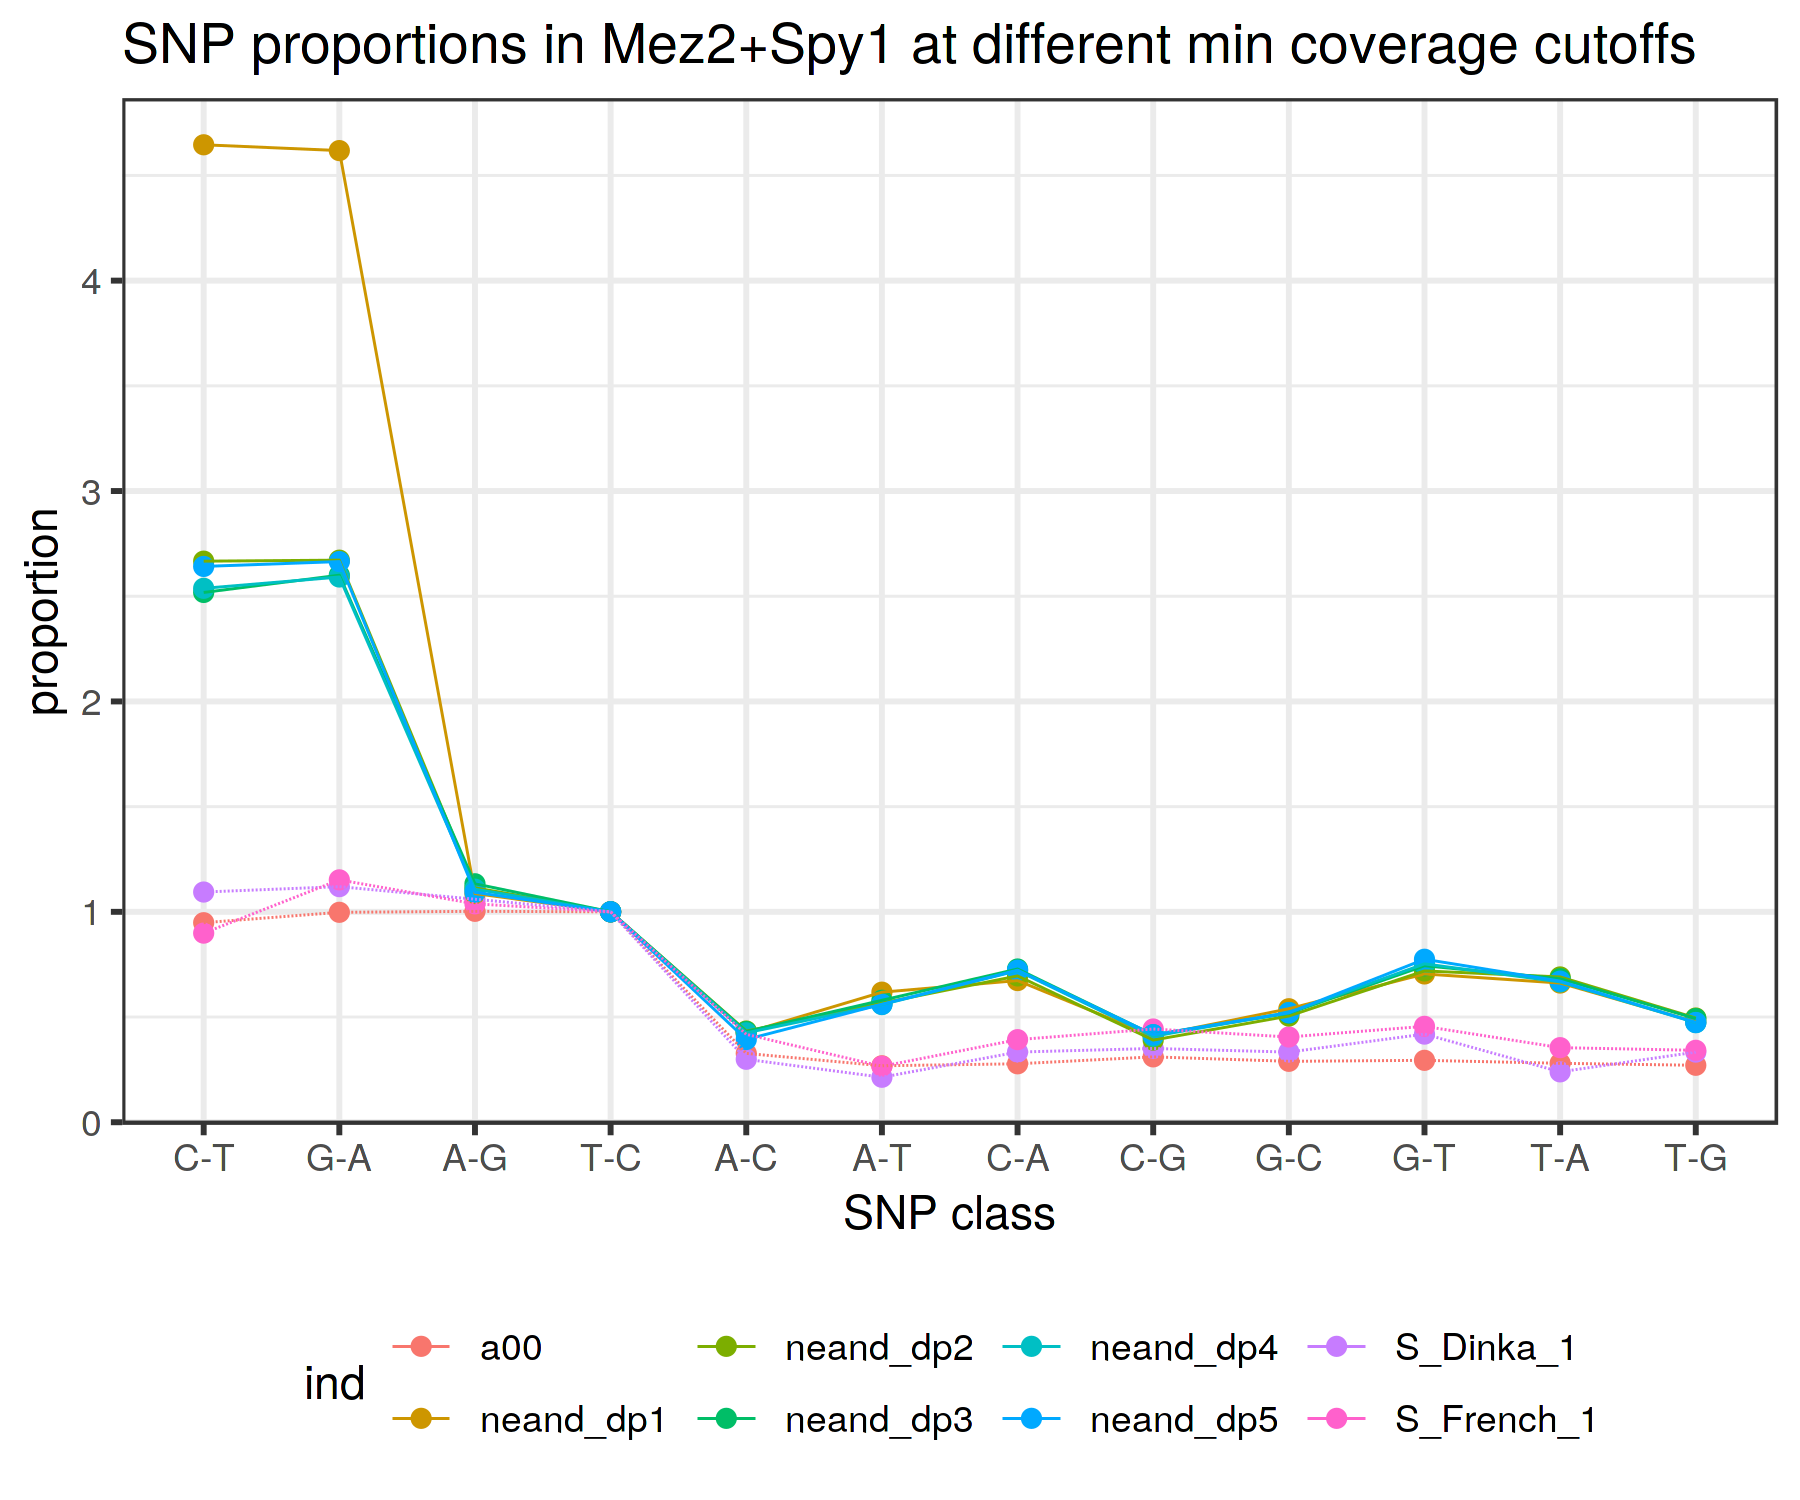

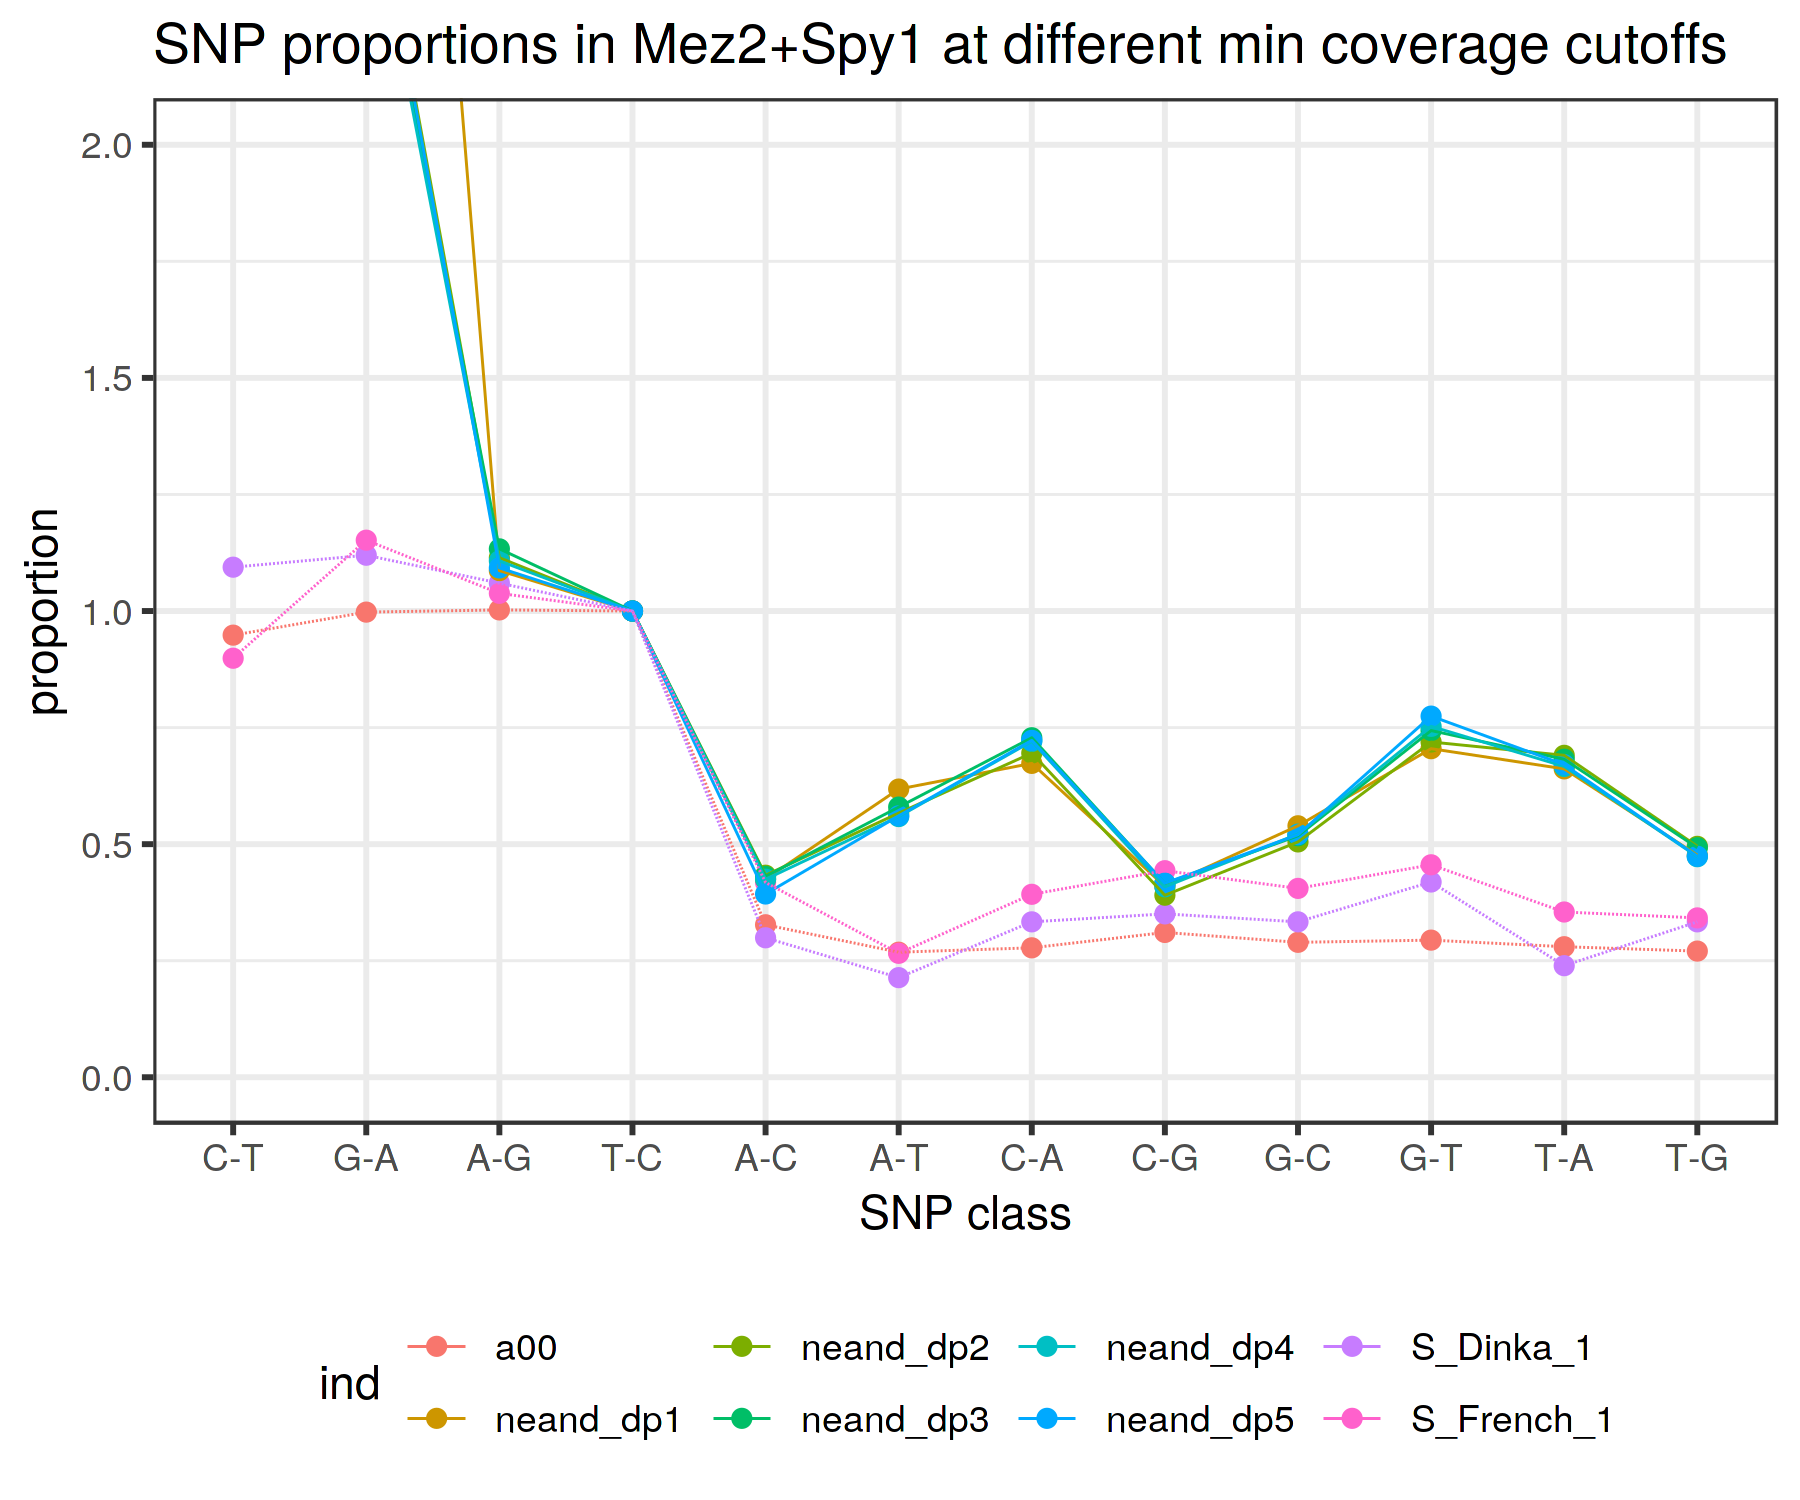

In [13]:
set_dim(6, 5)

neand_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez2+Spy1 at different min coverage cutoffs")

neand_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    coord_cartesian(y = c(0, 2)) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez2+Spy1 at different min coverage cutoffs")